In [258]:
# Import
import os

import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import pandas as pd

In [6]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWg5B7S039qX8u97Xd0sGW8g_ADBjyuxcDAMuz-i8sav696WcGImgC4

Successfully saved authorization token.


In [240]:
def get_ee_image(lng, lat):
    # Half width of geometry region
    _HW = 0.012

    point = ee.Geometry.Point(lng, lat)
    aoi = ee.Geometry.Polygon([[
        [lng - _HW, lat + _HW],
        [lng - _HW, lat - _HW],
        [lng + _HW, lat - _HW],
        [lng + _HW, lat + _HW],
    ]], None, False)

    img_col = (
        ee
        .ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(point)
        .filterDate('2020-09-01', '2021-09-21')
        .sort('CLOUDY_PIXEL_PERCENTAGE')
        .select(['B4', 'B3', 'B2'])
    )
    
    num_imgs = img_col.size().getInfo()
    if num_imgs == 0:
        return None

    img = (
        img_col
        .first()
        .clipToBoundsAndScale(
                geometry=aoi,
                width=512,
                height=512,
            )
    )

    return img

# Demo of one example

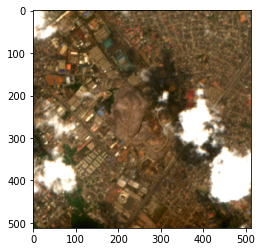

In [243]:
_lng = 3.3773
_lat = 6.595
_img = get_ee_image(_lng, _lat)
_rgb_img = geemap.ee_to_numpy(_img)
plt.imshow(_rgb_img.clip(0, 3000) / 3000)
plt.savefig('example.png')

# Process all examples in CSV

In [198]:
lf_df = pd.read_csv('Large_open_US_landfills.csv')
lf_df.head()

,Landfill_ID,Landfill_Name,Landfill_Alias,State,City,County,Zipcode,Latitude,Longitude,Ownership_Type,Year_opened,Landfill_Closure_Year,Status,Current_Area,Current_Depth,Design_Capacity_tons,Waste_in_Place_tons,Annual_waste_acceptance_rate_tons
0,352,Puente Hills LF,Puente Hills (PERG); San Gabriel Valley Dump,CA,Whittier,Los Angeles,90601.0,34.020330,-118.006040,Public,1957.0,2013.0,Closed,590.0,229.5,142400000.0,142250454.0,2135318.0
1,966,Fresh Kills SLF,NaN,NY,Staten Island,Richmond,10312.0,40.572000,-74.188000,Public,1948.0,2002.0,Closed,1416.0,NaN,135450945.0,135450945.0,1014300.0
2,1465,McCarty Road LF,NaN,TX,Houston,Harris,77078.0,29.827501,-95.243334,Private,1972.0,2031.0,Open,388.0,NaN,123783905.0,97983501.0,1834618.0
3,232,Olinda Alpha SLF,Olinda SLF,CA,Brea,Orange,92823.0,33.933610,-117.843610,Public,1960.0,2021.0,Open,420.0,235.0,96736556.0,86320460.0,2331531.0
4,930,Apex Regional LF,NaN,NV,Las Vegas,Clark,89165.0,36.374000,-114.865180,Private,1993.0,2365.0,Open,297.0,300.0,994920296.0,72848073.0,2804493.0


In [259]:
IMAGES_DIR = 'landfill_images'

# for lat, lng in lf_df[['Latitude', 'Longitude']].dropna().values:
# for lng, lat in lf_df[['Longitude', 'Latitude']].dropna().values:
for row in lf_df.dropna(subset=['Longitude', 'Latitude']).itertuples():
    print(f'Processing #{row.Index}, id={row.Landfill_ID}, latlng=({row.Latitude:.2f}, {row.Longitude:.2f})')
    
    if os.path.exists(f'{IMAGES_DIR}/{row.Landfill_ID}.png'):
        print(f'Skip: file exists: {IMAGES_DIR}/{row.Landfill_ID}.png')
        continue

    img = get_ee_image(row.Longitude, row.Latitude)
    if img is None:
        print(f'Skip: Not found image')
        continue

    rgb_img = geemap.ee_to_numpy(img)
    if rgb_img is None:
        print(f'Skip: fail to convert to numpy')
        continue
    
    # Normalize rgb img to [0, 1].
    rgb_img = rgb_img.clip(0, 3000) / 3000

    # plt.imshow(rgb_img)
    plt.imsave(f'{IMAGES_DIR}/{row.Landfill_ID}.png', rgb_img)

Processing #0, id=352, latlng=(34.02, -118.01)
Skip: file exists: landfill_images/352.png
Processing #1, id=966, latlng=(40.57, -74.19)
Skip: file exists: landfill_images/966.png
Processing #2, id=1465, latlng=(29.83, -95.24)
Skip: file exists: landfill_images/1465.png
Processing #3, id=232, latlng=(33.93, -117.84)
Skip: file exists: landfill_images/232.png
Processing #4, id=930, latlng=(36.37, -114.87)
Skip: file exists: landfill_images/930.png
Processing #5, id=397, latlng=(26.28, -80.16)
Skip: file exists: landfill_images/397.png
Processing #6, id=1718, latlng=(39.66, -104.69)
Skip: file exists: landfill_images/1718.png
Processing #7, id=1461, latlng=(33.02, -96.96)
Skip: file exists: landfill_images/1461.png
Processing #8, id=1879, latlng=(42.41, -83.56)
Skip: file exists: landfill_images/1879.png
Processing #9, id=1249, latlng=(40.16, -74.78)
Skip: file exists: landfill_images/1249.png
Processing #10, id=286, latlng=(34.32, -118.50)
Skip: file exists: landfill_images/286.png
Proce

Processing #142, id=1242, latlng=(45.74, -119.62)
Processing #143, id=987, latlng=(42.58, -78.50)
Processing #145, id=268, latlng=(33.08, -117.17)
Processing #146, id=1270, latlng=(39.97, -77.56)
Processing #147, id=1260, latlng=(40.13, -77.50)
Processing #148, id=12141, latlng=(33.18, -112.66)
Processing #149, id=217, latlng=(36.71, -121.77)
Processing #150, id=1687, latlng=(44.29, -88.35)
Processing #151, id=11822, latlng=(26.40, -98.13)
Processing #152, id=730, latlng=(30.60, -91.23)
Processing #153, id=12101, latlng=(29.40, -95.73)
Processing #154, id=12201, latlng=(33.30, -96.52)
Processing #155, id=1298, latlng=(40.81, -80.08)
Processing #156, id=1571, latlng=(37.31, -78.06)
Processing #157, id=2315, latlng=(41.34, -88.13)
Processing #158, id=476, latlng=(41.64, -87.59)
Processing #159, id=1485, latlng=(32.36, -97.20)
Processing #160, id=1738, latlng=(40.58, -104.83)
Processing #161, id=20711, latlng=(39.74, -82.16)
Image.sampleRectangle: Fully masked pixels / pixels outside of t

# Below: Unused functions

In [7]:
img = ee.Image('LANDSAT/LC08/C01/T1_SR/LC08_038029_20180810') \
  .select(['B4', 'B5', 'B6'])

aoi = ee.Geometry.Polygon(
  [[[-110.8, 44.7],
    [-110.8, 44.6],
    [-110.6, 44.6],
    [-110.6, 44.7]]], None, False)

rgb_img = geemap.ee_to_numpy(img, region=aoi)
print(rgb_img.shape)

(373, 531, 3)


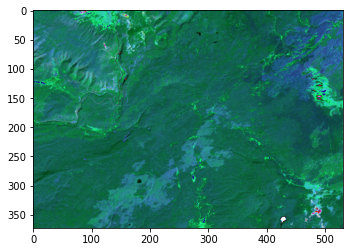

In [44]:
def rgb_to_norm256(rgb_img):
    return 255 * ((rgb_img[:, :, 0:3] - 100)/3500)


def norm256_to_rgb(norm256_img):
    return (norm256_img.astype('float') / 255.0) * 3500 + 100


def display_image(rgb_img):
    # Scale the data to [0, 255] to show as an RGB image. 
    # Adapted from https://bit.ly/2XlmQY8. Credits to Justin Braaten
    rgb_img_test = norm256(rgb_img).astype('uint8')
    plt.imshow(rgb_img_test)
    plt.show()


display_image(rgb_img)

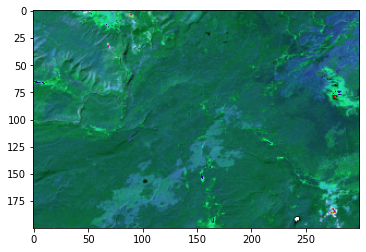

In [45]:
# Resize to a fixed dimension.
def resize(rgb_img, output_shape):
    return skimage.transform.resize(
        rgb_img,
        output_shape=output_shape,
        preserve_range=True)


display_image(resize(rgb_img, [200, 300]))

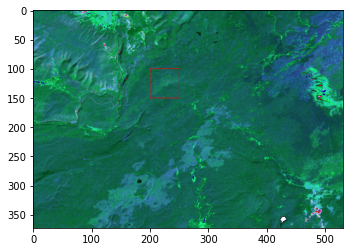

In [50]:
def draw_bbox(rgb_img, r1, c1, height, width):
    norm256_img = rgb_to_norm256(rgb_img)
    r2 = r1 + height
    c2 = c1 + width
    
    # Columns
    for c in [c1, c2]:
        norm256_img[r1:r2, c, 0] = 255
        norm256_img[r1:r2, c, 1] = 0
        norm256_img[r1:r2, c, 2] = 0
    
    # Rows
    for r in [r1, r2]:
        norm256_img[r, c1:c2, 0] = 255
        norm256_img[r, c1:c2, 1] = 0
        norm256_img[r, c1:c2, 2] = 0
    
    return norm256_to_rgb(norm256_img)


display_image(draw_bbox(rgb_img, 100, 200, 50, 50))